# Exploring ODF Extraction
## Sam Potter
## Current: 4/1/19

## Path and Imports

In [1]:
import sys
import os

sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\dic',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/dic'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/dic'])
from dic import visualize
from dic import fileIO
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import rc
from dic import utilities
import seaborn as sns
import cv2
import matplotlib

from ipywidgets import *
from scipy import optimize as sciopt

## Magics

In [2]:
%matplotlib inline

## Optical Mathematics

### Cylindrical scattering for single fiber

$I_{fiber}(\theta) = a_0 + a_2 \cos(2(\theta - \phi)) + a_4 \cos(4(\theta - \phi))$

### Cylindrical scattering for a distribution of fibers

$I_{dist}(\theta) = \int_{-\pi/2}^{\pi/2} I_{fiber}(\theta) PDF_{dist}(\theta) d \theta$

NOTE, CONVOLUTION OPERATION IS TREATED AS JUST SUMMATION AND NORMALIZATION IN THE WORK BELOW. CORRECT???

## Setup Single Fiber Cosine Series

### Definition of single fiber function

In [3]:
def Ifiber(a0, a2, a4, phi, numpts=100, normalize=True):
    
    theta = np.linspace(-90, 90, numpts)
    
    vals = a0 + a2 * np.cos(np.deg2rad(2 * (theta - phi))) + a4 * np.cos(np.deg2rad(4 * (theta - phi)))
    
    if normalize:
        vals = utilities.normalize_1d(vals)
    
    return vals, theta

In [4]:
def Ifiber_interactive(a0, a2, a4, phi, numpts=100, normalize=True):
    
    theta = np.linspace(-90, 90, numpts)
    
    vals = a0 + a2 * np.cos(np.deg2rad(2 * (theta - phi))) + a4 * np.cos(np.deg2rad(4 * (theta - phi)))
    
    if normalize:
        vals = utilities.normalize_1d(vals)
    
    fig = plt.figure(figsize=(10, 10))
    plt.plot(theta, vals, color='g', label='Intensity');
    plt.legend(prop={'size': 18});
    plt.xlabel(r'$\theta$', fontsize=18);
    plt.ylabel('Normalized Intensity (a.u.)', fontsize=18);
    plt.title('Normalized Intensity Curves of Single Fiber under Cylindrical Scattering', fontsize=18);
    plt.autoscale(enable=True, axis='x', tight=True)
    
    print('a2/a4: {}'.format(a2/a4))

### Plot a sample intensity function

In [5]:
p = interactive(Ifiber_interactive, a0=(0, 1, 0.1), a2=(0, 0.05, 0.005), a4=(0, 0.2, 0.02), phi=(-90, 90, 5), numpts=(100, 500, 10))
display(p)

interactive(children=(FloatSlider(value=0.0, description='a0', max=1.0), FloatSlider(value=0.025, description=…

## Look at Fiber Distributions

### Setup Uniform Distribution

In [6]:
samples = np.random.uniform(-45, 45, 10000)

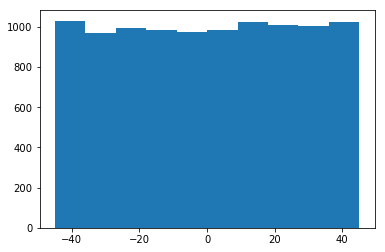

In [7]:
plt.hist(samples);

### Setup Normal Distribution

In [8]:
samples = np.random.normal(0, 45, 10000)

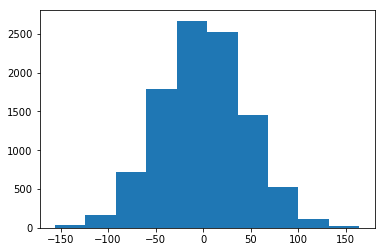

In [9]:
plt.hist(samples);

### Setup and generate samples

In [10]:
def syntheticIdist(a0, a2, a4, splay, nsamples, distribution='uniform'):
    
    ntheta = 100
    Idist = np.zeros((nsamples, ntheta))
    for i in range(0, nsamples):
        if distribution == 'uniform':
            phi = np.random.uniform(-1*splay, splay)
        elif distribution == 'normal':
            phi = np.random.normal(0, splay)

        vals, theta_dist = Ifiber(a0, a2, a4, phi, numpts=ntheta, normalize=False)
        Idist[i, :] = vals

    Idist = np.sum(Idist, axis=0) / nsamples
    #Idist = utilities.normalize_1d(Idist)
    
    return Idist

In [11]:
def compareI(a0, a2, a4, phi0, splay, nsamples, distribution='uniform'):
    
    ntheta = 100
    Idist = np.zeros((nsamples, ntheta))
    if distribution == 'uniform':
        phis = np.random.uniform(-1*splay, splay, nsamples)
    elif distribution == 'normal':
        phis = np.random.normal(0, splay, nsamples)
    for i in range(0, nsamples):
        phi = phis[i]
        vals, theta_dist = Ifiber(a0, a2, a4, phi, numpts=ntheta, normalize=False)
        Idist[i, :] = vals

    Idist = np.sum(Idist, axis=0) / nsamples
    #Idist = utilities.normalize_1d(Idist)
    
    Ifibers, theta_fiber = Ifiber(a0, a2, a4, phi0, numpts=ntheta, normalize=False)
    
    fig = plt.figure(figsize=(10, 10))
    plt.plot(theta_fiber, Ifibers, color='g', label='Single Fiber Intensity');
    plt.plot(theta_dist, Idist, color='r', label='Fiber Distribution Intensity');
    plt.legend(prop={'size': 14}, loc='best');
    plt.xlabel(r'$\theta$', fontsize=18);
    plt.ylabel('Intensity (a.u.)', fontsize=18);
    plt.title('Intensity Curves from Single Fiber and a Distribution of Fibers', fontsize=18);
    #plt.ylim(0, 1.25)
    plt.autoscale(enable=True, axis='x', tight=True)
    
    fig = plt.figure(figsize=(10, 10))
    plt.hist(phis)
    plt.title('Historgram of phi')
    plt.xlabel('phi')
    

In [12]:
p = interactive(compareI, a0=(0, 1, 0.1), a2=(0, 0.05, 0.005), a4=(0, 0.2, 0.02), phi0=(-90, 90, 5), splay=(0, 90, 5), nsamples=(10, 10000, 100))
display(p)

interactive(children=(FloatSlider(value=0.0, description='a0', max=1.0), FloatSlider(value=0.025, description=…

## See if I can fit the new a0, a2, and a4 terms from the Idist

In [13]:
def minimand(a0, a2, a4, phi, data):
    
    theta = np.linspace(-90, 90, len(data))
    
    feval = a0 + a2 * np.cos(np.deg2rad(2 * (theta - phi))) + a4 * np.cos(np.deg2rad(4 * (theta - phi)))
    
    diff = data - feval
    
    diffsq = np.square(diff, diff)
    
    ssd = np.sum(diffsq)
    
    return ssd

In [14]:
def minfun(params, *args):

    return minimand(params[0], params[1], params[2], params[3], *args)

In [15]:
a0 = 0
a2 = 0.0652
a4 = 0.2489
phi = 0
splay = 30
nsamples = 10000
Isingle_data, theta_single = Ifiber(a0, a2, a4, phi, normalize=False)
Idist_data = syntheticIdist(a0, a2, a4, splay, nsamples, distribution='normal')
minimand(a0, a2, a4, phi, Idist_data)

2.519318245736313

### Find the distribution terms

### Plot the data first

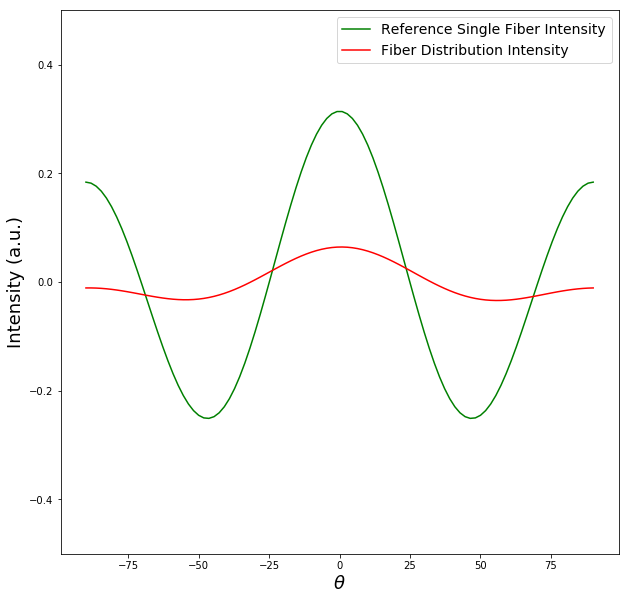

In [16]:
theta = np.linspace(-90, 90, 100)
fig = plt.figure(figsize=(10, 10))
plt.plot(theta, Isingle_data, color='g', label='Reference Single Fiber Intensity')
plt.plot(theta, Idist_data, color='r', label='Fiber Distribution Intensity');
plt.legend(prop={'size': 14}, loc='best');
plt.xlabel(r'$\theta$', fontsize=18);
plt.ylabel('Intensity (a.u.)', fontsize=18);
plt.ylim(-.5, .5);

### Minimize to find the parameter values

In [17]:
args_tup = (Idist_data)
int_x = np.array([.6, 0.025, .15, 0])
bounds = ((0, 1), (-1, 1), (0, 1), (-90, 90))
res = sciopt.minimize(minfun, int_x, args=args_tup, bounds=bounds, method='L-BFGS-B', jac='2-point')

In [18]:
print('Final values of a0, a2, a4, phi: {}'.format(res.x))
print('Final residual: {}'.format(res.fun))

Final values of a0, a2, a4, phi: [0.         0.03764623 0.02670904 0.00045183]
Final residual: 9.870667875744044e-05


### Plot fit results

In [19]:
a0f = res.x[0]
a2f = res.x[1]
a4f = res.x[2]
phif = res.x[3]

Ifit, theta_fit = Ifiber(a0f, a2f, a4f, phif, normalize=False)

Single Fiber a2: 0.0652, a4: 0.2489 and a2/a4: 0.26195259140216953
Fit Fiber Distribution a2: 0.037646234865625405, a4: 0.026709035122931844 and a2/a4: 1.4094943786757426


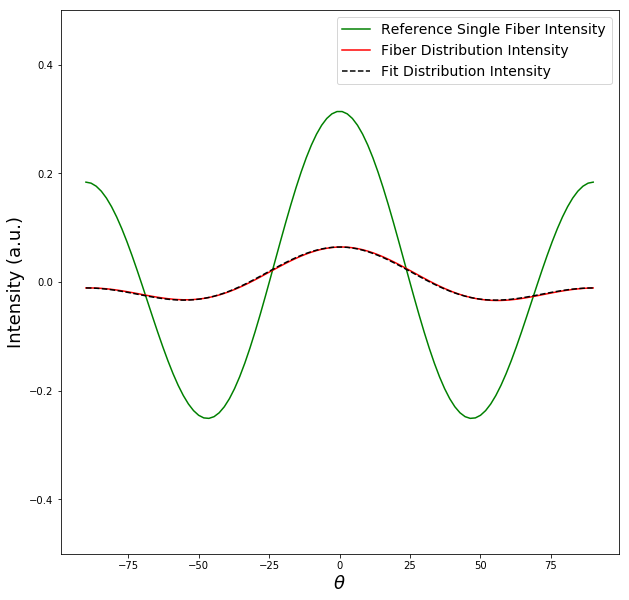

In [20]:
theta = np.linspace(-90, 90, 100)
fig = plt.figure(figsize=(10, 10))
plt.plot(theta, Isingle_data, color='g', label='Reference Single Fiber Intensity')
plt.plot(theta, Idist_data, color='r', label='Fiber Distribution Intensity');
plt.plot(theta, Ifit, color='k', ls='dashed', label='Fit Distribution Intensity')
plt.legend(prop={'size': 14}, loc='best');
plt.xlabel(r'$\theta$', fontsize=18);
plt.ylabel('Intensity (a.u.)', fontsize=18);
plt.ylim(-.5, .5);
print('Single Fiber a2: {}, a4: {} and a2/a4: {}'.format(a2, a4, a2/a4))
print('Fit Fiber Distribution a2: {}, a4: {} and a2/a4: {}'.format(a2f, a4f, a2f/a4f))

## Look at ODF data from SALS and compare with pSFDI a0, a2, a4

### Load in pSFDI Data

In [21]:
pSFDI_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\3.24.19b\\2) pSFDI\\V_Green\data_proc.mat'
pSFDI_data = fileIO.read_mat_file(pSFDI_data_path)

phi = pSFDI_data['phi']
a0 = pSFDI_data['a0']
a2 = pSFDI_data['a2']
a4 = pSFDI_data['a4']
DOA = pSFDI_data['DOA']

### Visualize data

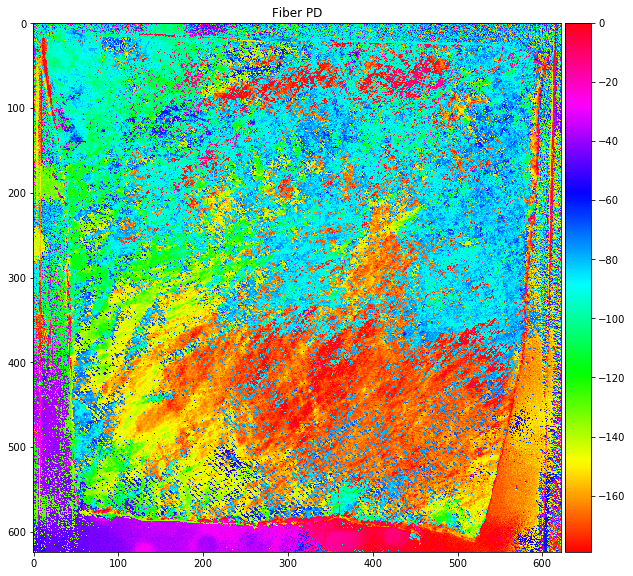

In [22]:
# PD
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(phi, cmap='hsv');
plt.title('Fiber PD');
ax = plt.gca();
divider = make_axes_locatable(ax);
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im0, cax=cax);

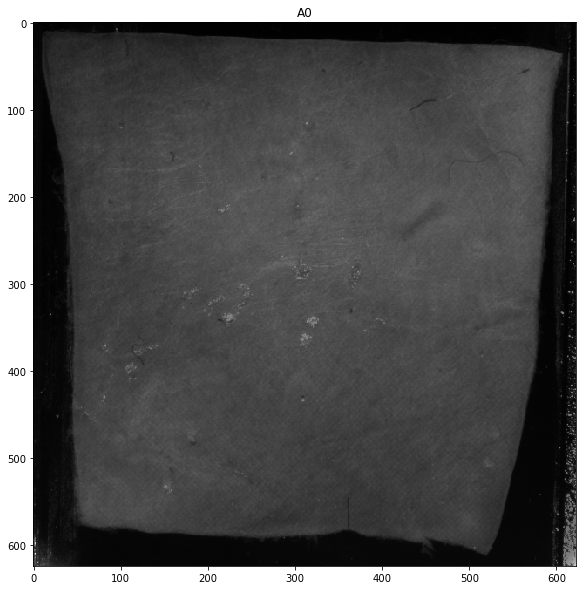

In [23]:
# a0
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(a0, cmap='gray')
plt.title('A0');

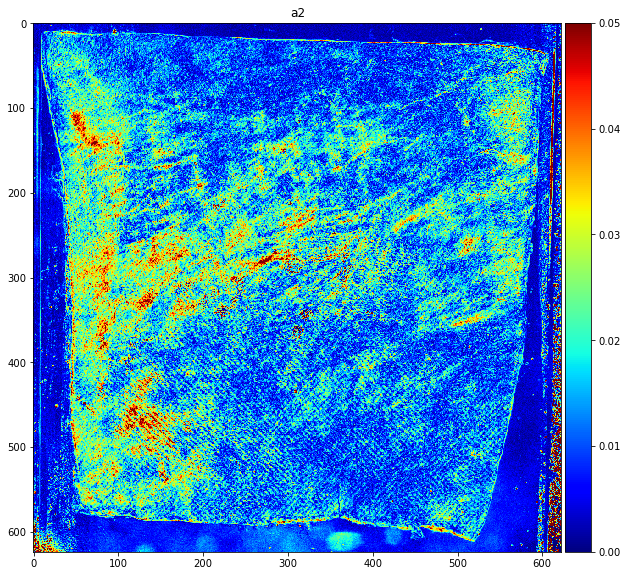

In [24]:
# a2
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(a2, cmap='jet')
plt.title('a2')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 0.05);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

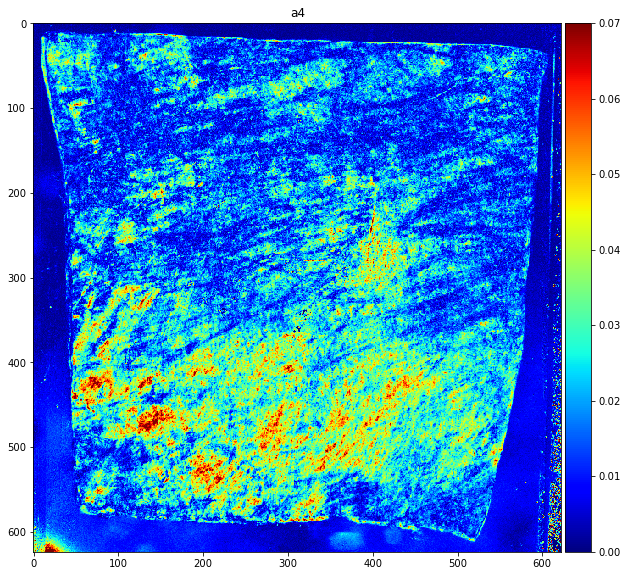

In [25]:
# a4
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(a4, cmap='jet')
plt.title('a4')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 0.07);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

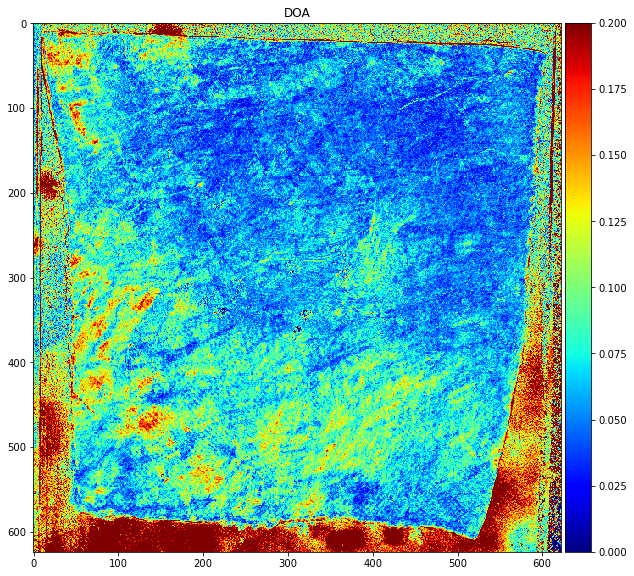

In [26]:
# DOA
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(DOA, cmap='jet')
plt.title('DOA')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, .2);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

### Visualize a2/a4 ratio

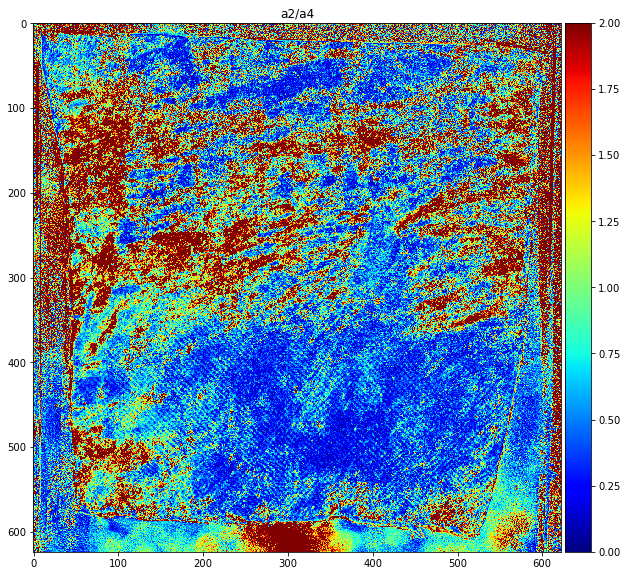

In [27]:
a2a4 = a2/a4
# a2/a4
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(a2a4, cmap='jet')
plt.title('a2/a4')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 2);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

### Load in SALS data

In [28]:
SALS_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\Results\\BP ODF 032919\\SALSA OUT TXT\\BP_ODF_Extraction_032919_SALSA.txt'

# Manually parse data
# Open and file and get data
f = open(SALS_data_path, 'r')
SALS_string_data = f.readlines()
SALS_string_list = [line.split('\t') for line in SALS_string_data]
f.close()

# Get variables of interest
SALS_PD = [row[2] for row in SALS_string_list]
SALS_SD = [row[6] for row in SALS_string_list]
x = [row[0] for row in SALS_string_list]
y = [row[1] for row in SALS_string_list]

# Convert strings to floats
SALS_PD = list(map(float, SALS_PD[1:]))
SALS_SD = list(map(float, SALS_SD[1:]))
x = list(map(float, x[1:]))
y = list(map(float, y[1:]))

# Convert lists to numpy arrays
SALS_PD = np.array(SALS_PD)
SALS_SD = np.array(SALS_SD)
x = np.array(x)
y = np.array(y)

In [61]:
# Reshape the data
y_step = y[1] - y[0]
ydim = int(np.max(y) / y_step + 1)
xdim = int(len(y) / ydim)

x_2d = np.reshape(x, (xdim, ydim)).T
y_2d = np.reshape(y[::-1], (xdim, ydim)).T
PD_2d = np.reshape(SALS_PD, (xdim, ydim)).T
PD_2d = np.rad2deg(PD_2d)  # Convert radians to degrees
SD_2d = np.reshape(SALS_SD, (xdim, ydim)).T
SD_2d = np.rad2deg(SD_2d)  # Convert radians to degrees

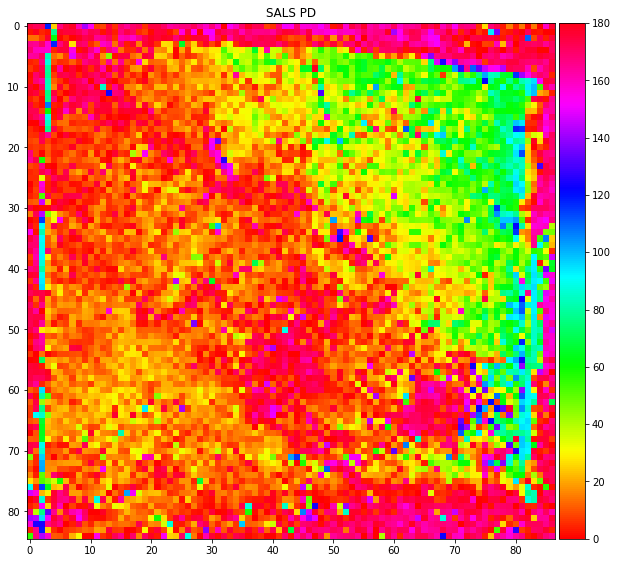

In [62]:
# SALS PD
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(PD_2d, cmap='hsv')
plt.title('SALS PD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 180);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

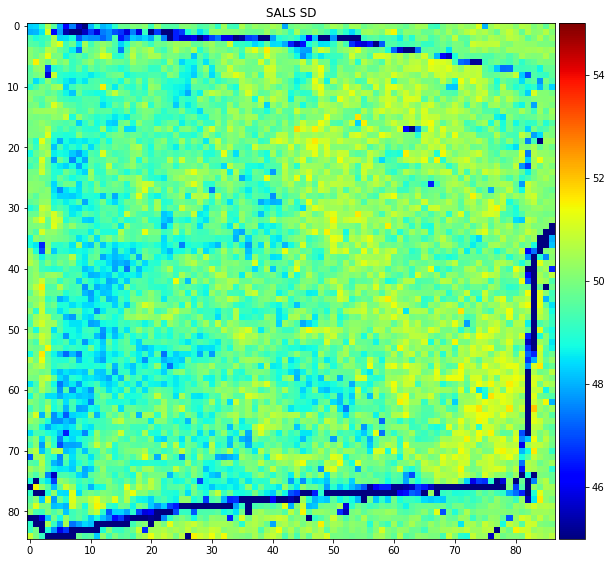

In [68]:
# SALS SD
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(SD_2d, cmap='jet')
plt.title('SALS SD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (45, 55);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

In [69]:
# Save a file for masking a mask
name = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\Results\\BP ODF 032919\\BW_Images\\color_premask.png'
plt.imsave(name, SD_2d, format='png', cmap='jet', vmin=45, vmax=55)

### Register and resample images

In [33]:
# Binary mask of pSFDI image
psfdi_mask_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\3.24.19b\\2) pSFDI\\V_Green\mask.tif'
psfdi_mask = cv2.imread(psfdi_mask_path, -1)

# Binary mask of SALS image
sals_mask_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\Results\\BP ODF 032919\\BW_Images\\Mask.tif'
sals_mask = cv2.imread(sals_mask_path, -1)

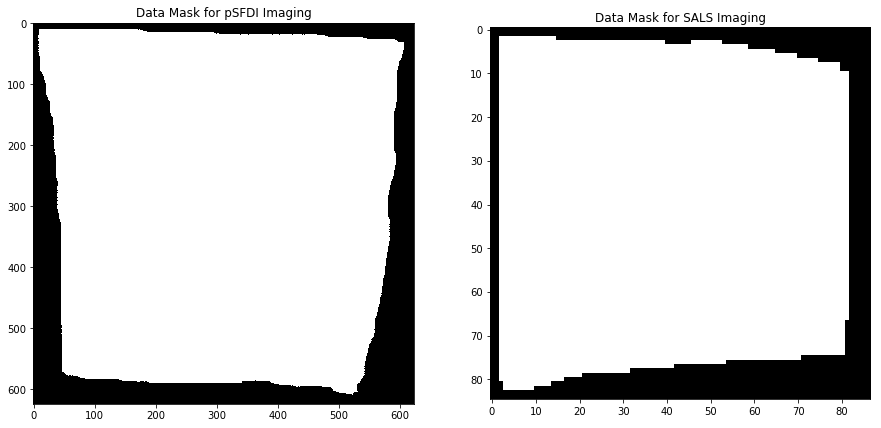

In [34]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
im0 = ax0.imshow(psfdi_mask, cmap='gray')
ax0.set_title('Data Mask for pSFDI Imaging');

im1 = ax1.imshow(sals_mask, cmap='gray')
ax1.set_title('Data Mask for SALS Imaging');

In [59]:
# upscale the psfdi data
# set the size of the upscaling
sals_rows, sals_columns = sals_mask.shape
psfdi_rows, psfdi_columns = psfdi_mask.shape

row_step = int(psfdi_rows / sals_rows)
col_step = int(psfdi_columns / sals_columns)

psfdi_mask_upscaled = np.zeros(sals_mask.shape)

for i in range(0, sals_rows):
    for j in range(0, sals_columns):
        subar = psfdi_mask[i * row_step: i * row_step + row_step, j * col_step: j * col_step + col_step]
        val = np.mean(subar)
        psfdi_mask_upscaled[i, j] = val

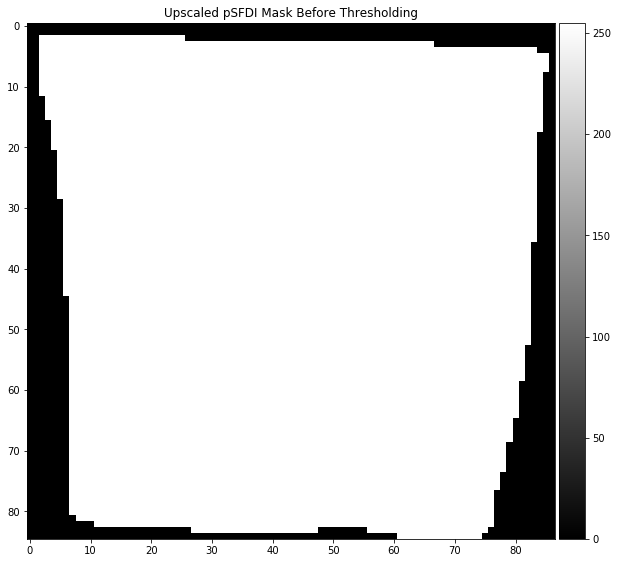

In [76]:
# Show the mask results without thresholding
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(psfdi_mask_upscaled, cmap='gray')
plt.title('Upscaled pSFDI Mask Before Thresholding')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im0, cax=cax);

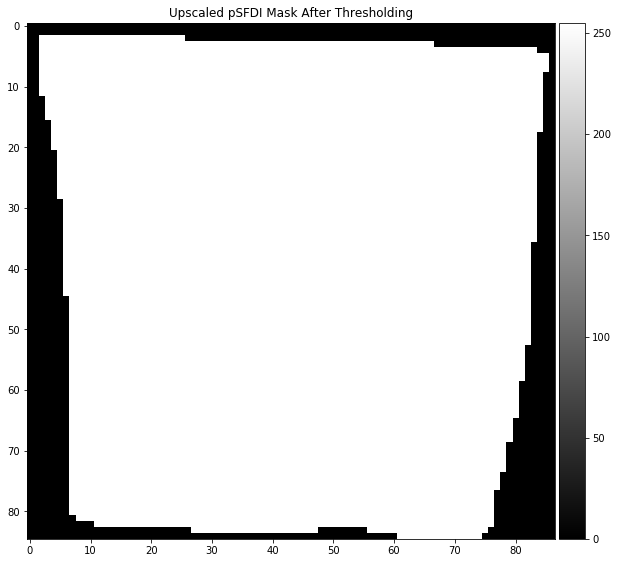

In [75]:
# Threshold mask, then plot
psfdi_mask_upscaled = psfdi_mask_upscaled >= 255
psfdi_mask_upscaled = 255 * psfdi_mask_upscaled.astype(int)

# Show the mask results without thresholding
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(psfdi_mask_upscaled, cmap='gray')
plt.title('Upscaled pSFDI Mask After Thresholding')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im0, cax=cax);

## Look at spread of possible a2/a4 combinations

In [ ]:
a2s = np.linspace(-1, 1, 100)
a4s = np.linspace(0.01, 1, 100)

a44, a22 = np.meshgrid(a4s, a2s)

In [ ]:
ratio = a22/a44

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(17, 17))
im0 = ax0.imshow(a22, cmap='jet')
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax0)
ax0.set_title('a2')

im1 = ax1.imshow(a44, cmap='jet')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1)
ax1.set_title('a4');

im2 = ax2.imshow(ratio, cmap='jet')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2)
ax2.set_title('a2/a4');

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(ratio, cmap='jet', extent=[0, 1, 1, -1], aspect='auto')
plt.colorbar();
plt.title('Ratio of a2/a4 over range of theoretical values of a2 and a4', size=15);
plt.xlabel('a4', size=18)
plt.ylabel('a2', size=18);

### Looking at 1D slices - Varying a4

In [ ]:
a2 = np.linspace(-1, 1, 5)
a4 = np.linspace(0.01, 1, 100)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(a4, a2[0] / a4, label='a2={}'.format(a2[0]));
plt.plot(a4, a2[1] / a4, label='a2={}'.format(a2[1]))
plt.plot(a4, a2[2] / a4, label='a2={}'.format(a2[2]))
plt.plot(a4, a2[3] / a4, label='a2={}'.format(a2[3]))
plt.plot(a4, a2[4] / a4, label='a2={}'.format(a2[4]))
plt.legend(prop={'size': 18});
plt.xlabel('a4', size=18)
plt.ylabel('a2/a4', size=18)
plt.title('1D Slice of a2/a4 - varying a4', size=16);

### Looking at 1D slices - Varying a2

In [ ]:
a2 = np.linspace(-1, 1, 100)
a4 = np.linspace(0.0, 1, 5)
print(a4)

In [ ]:
# Note leaving out the a4=0 as it leads to inf
fig = plt.figure(figsize=(10, 10))
plt.plot(a2, a2 / a4[1], label='a4={}'.format(a4[1]))
plt.plot(a2, a2 / a4[2], label='a4={}'.format(a4[2]))
plt.plot(a2, a2 / a4[3], label='a4={}'.format(a4[3]))
plt.plot(a2, a2 / a4[4], label='a4={}'.format(a4[4]))
plt.legend(prop={'size': 18});
plt.xlabel('a2', size=18)
plt.ylabel('a2/a4', size=18)
plt.title('1D Slice of a2/a4 - varying a2', size=16);

### Looking at 1D slices - Varying a4 - Looking at top 80% of a4 range

In [ ]:
a2 = np.linspace(-1, 1, 5)
a4 = np.linspace(0.01, 1, 100)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(a4, a2[0] / a4, label='a2={}'.format(a2[0]));
plt.plot(a4, a2[1] / a4, label='a2={}'.format(a2[1]))
plt.plot(a4, a2[2] / a4, label='a2={}'.format(a2[2]))
plt.plot(a4, a2[3] / a4, label='a2={}'.format(a2[3]))
plt.plot(a4, a2[4] / a4, label='a2={}'.format(a2[4]))
plt.legend(prop={'size': 18});
plt.xlabel('a4', size=18)
plt.ylabel('a2/a4', size=18)
plt.xlim(0.2, 1.0)
plt.ylim(-5, 5)
plt.title('1D Slice of a2/a4 - varying a4', size=16);

### Histogram a2/a4

In [ ]:
ratio_flat = np.ndarray.flatten(ratio)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.boxplot(ratio_flat, showfliers=False);

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.hist(ratio_flat);

### Effects of fiber population splay on a2/a4 ratios

Note, this doesn't really reflect range of a2/a4 from real single fiber types. Need to get that from the literature. This is just to scope.

SOMETHING SEEMS WRONG

In [ ]:
# Specify range of a2/a4 to be [-4, 4]
# Accomplish this by fixing a4=0.25 and letting a2 range [-1, 1]
a2 = np.linspace(-1, 1, 20)
a4 = 0.25
a2a4 = a2 / a4

In [ ]:
# Specify range of sigma
sigma = np.linspace(0, 90, 19)

In [ ]:
# Loop over a2/a4
# Loop over splay
# Compute a2/a4 of a distribution, use a2 and a4 as a starting point
# Store this in th earray

phi = 0
a0 = 0
nsamples = 10000
bounds = ((0, 1), (-1, 1), (0, 1), (-90, 90))

a2a4_dist = np.zeros((len(a2/a4), len(sigma)))
residualmat = np.zeros((len(a2/a4), len(sigma)))
for i in range(0, len(a2a4)):
    for j in range(0, len(sigma)):
        a2 = a2a4[i] * a4
        # Generate a synthetic distribution
        Idist_data = syntheticIdist(a0, a2, a4, splay, nsamples, distribution='normal')
        # Fit that data
        args_tup = (Idist_data)
        int_x = np.array([a0, a2, a4, phi])
        minresult = sciopt.minimize(minfun, int_x, args=args_tup, bounds=bounds, method='L-BFGS-B', jac='2-point')
        a0f = minresult.x[0]
        a2f = minresult.x[1]
        a4f = minresult.x[2]
        phif = minresult.x[3]
        residual = minresult.fun
        a2a4f = a2f/a4f
        
        a2a4_dist[i, j] = a2a4f
        residualmat[i, j] = residual

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(a2a4_dist, cmap='jet', extent=[0, 90, 4, -4], aspect='auto')
plt.colorbar();
plt.title('Distribution a2/a4 from given a2/a4 single fiber input and distribution splay', size=15);
plt.xlabel('sigma', size=18)
plt.ylabel('a2/a4', size=18);

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(residualmat, cmap='jet', extent=[0, 90, 4, -4], aspect='auto')
plt.colorbar();
plt.title('Residuals from minimization process', size=15);
plt.xlabel('sigma', size=18)
plt.ylabel('a2/a4', size=18);

In [ ]:
a2a4_stacked = np.zeros((len(a2a4), 19))
for i in range(0, 19):
    a2a4_stacked[:, i] = a2a4

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(a2a4_stacked, cmap='jet', extent=[0, 90, 4, -4], aspect='auto')
plt.colorbar();
plt.title('Distribution a2/a4 from given a2/a4 single fiber input and distribution splay', size=15);
plt.xlabel('sigma', size=18)
plt.ylabel('a2/a4', size=18);